# Code for running Caffe toolbox
* **Objectives:** 
    1. Define feed-forward partitioned nets (APANN)
    2. Train and test nets on HC, CT and HC+CT input modalities        
        a. Hyper-parameter search
        b. 10 rounds 10-kf validation


* **Other functions:**
    1. Net surgery to copy weights from pre-trained nets 


* **Useful links**
    
    1. http://stackoverflow.com/questions/33140000/how-to-feed-caffe-multi-label-data-in-hdf5-format
    2. http://nbviewer.jupyter.org/github/BVLC/caffe/blob/master/examples/00-classification.ipynb
    3. http://nbviewer.jupyter.org/github/BVLC/caffe/blob/master/examples/01-learning-lenet.ipynb



In [1]:
from pylab import *
import h5py
import shutil
import tempfile
import sys
import caffe
import os
import sys
from scipy import stats
from sklearn.metrics import mean_squared_error as mse
import pickle
import subprocess as sub
from collections import defaultdict
import itertools
import pickle
import time
import datetime
import matplotlib.pyplot as plt
import tables as tb
from sklearn import preprocessing
import collections

caffe_root = '/home/nikhil/caffe/'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')

baseline_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/NN_MC/'
os.chdir(baseline_dir)

caffe.set_device(1)
caffe.set_mode_gpu()

#plt.style.use('ggplot')
%matplotlib inline

In [2]:
# Some defs
#Loads hdf datasets with a preprocessing option
def load_data(data_path, input_node, preproc):
    data = tb.open_file(data_path, 'r')
    X_raw = data.get_node('/' + input_node)[:]
    if preproc == 'scale':
        X = preprocessing.scale(X_raw)
    elif preproc == 'norm_max':
        X = preprocessing.normalize(X_raw, norm='max')
    elif preproc == 'norm_l2':
        X = preprocessing.normalize(X_raw, norm='l2')
    else:
        X = X_raw
    data.close()
    return X

# Save data to disk
def pickleIt(my_data,save_path):
    f = open(save_path, 'wb')
    pickle.dump(my_data, f)
    f.close()

# extract encodings (specifically multi-task outputs) from trained net
def extract_features(net_file, model_file, data_path, input_nodes, batch_size, encoding_layer, weight_layers, multi_task):
    os.chdir(os.path.dirname(net_file))
    net = caffe.Net(net_file, model_file, caffe.TEST)        
    
    #print net.blobs.items()[0]
    #print net.blobs.items()[1]
    
    #Get weights    
    layer_list = weight_layers
    wt_dict = collections.OrderedDict()
    for l, name in enumerate(net._layer_names):            
        if name in layer_list:
            wt_dict[name] = net.layers[l].blobs[0].data
    
    BATCH_SIZE = batch_size        
    N = load_data(data_path, input_nodes[0],'no_preproc').shape[0]
    iters = int(np.ceil(N / float(BATCH_SIZE)))

    if not multi_task:
        code_layer = net.blobs[encoding_layer]
        out_shape = code_layer.data.shape    
        X_out = np.zeros(shape=(N, out_shape[1]))        
        #print 'X_out.shape: {}'.format(X_out.shape)
        
    else:
        code_layer_adas13 = net.blobs[encoding_layer + '_ADAS13']
        code_layer_mmse = net.blobs[encoding_layer + '_MMSE']
        out_shape = code_layer_adas13.data.shape 
        X_out_adas13 = np.zeros(shape=(N, out_shape[1]))
        X_out_mmse = np.zeros(shape=(N, out_shape[1]))
        #print 'X_out.shape: {},{}'.format(X_out_adas13.shape,X_out_mmse.shape)
    
    X_list = []
    data_layers = []
    for i, input_node in enumerate(input_nodes):
        X_list.append(load_data(data_path, input_node,'no_preproc'))
        #print net.blobs[input_node].shape
        
        data_layers.append(net.blobs[input_node])    
        #print 'X_list shape: {}'.format(X_list[i].shape)
        #print 'data_layers shape: {}'.format(data_layers[i].data.shape)
        data_layers[i].reshape(BATCH_SIZE, X_list[i].shape[1]) # TODO: only works for 2-D inputs
        #print 'data_layers shape: {}'.format(data_layers[i].data.shape)
    
     
    net.reshape()            
    #print 'Extracting features from data...'
    
    for i in xrange(iters):
        #print '.',
        for m, X in enumerate(X_list):
            X_b = X[i * BATCH_SIZE: (i+1) * BATCH_SIZE,:]
            batch_sampx = X_b.shape[0]
            # Pad last batch with zeros
            if X_b.shape[0] < BATCH_SIZE:
                #print 'Zero-padding last batch with {} rows'.format(BATCH_SIZE-X_b.shape[0])
                X_b = np.vstack((X_b,np.zeros((BATCH_SIZE-X_b.shape[0],X_b.shape[1]))))                       
            
            data_layers[m].data[...] = X_b
            
        net.forward()
        
        if not multi_task:
            X_out[i * BATCH_SIZE: min((i+1) * BATCH_SIZE, N)] = code_layer.data[0:batch_sampx,:].copy()
        else:
            X_out_adas13[i * BATCH_SIZE: min((i+1) * BATCH_SIZE, N)] = code_layer_adas13.data[0:batch_sampx,:].copy()
            X_out_mmse[i * BATCH_SIZE: min((i+1) * BATCH_SIZE, N)] = code_layer_mmse.data[0:batch_sampx,:].copy()
            X_out = {'adas13':X_out_adas13,'mmse':X_out_mmse}
    return {'X_out':X_out, 'wt_dict':wt_dict}

# Defs for defining multi-task nets for different input modalities 
* **Input modalities:** 
    1. HC segmentations (L+R)
    2. CT values
    3. Both

In [9]:
from caffe import layers as L
from caffe import params as P

def adninet_ff_HC(hdf5, batch_size, node_sizes, dr, lr, tr, Clinical_Scale):
    n = caffe.NetSpec()
    
    #------- Input -----------------#
    if Clinical_Scale == 'ADAS13':
        n.X_L_HC,n.X_R_HC,n.adas  = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5,ntop=3) #orig
    elif Clinical_Scale == 'MMSE':
        n.X_L_HC,n.X_R_HC,n.mmse  = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5,ntop=3) #orig
    elif Clinical_Scale == 'BOTH':
        n.X_L_HC,n.X_R_HC,n.adas,n.mmse  = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5,ntop=4) #orig
    else:
        print 'Unknow Clinical Scale: {}'.format(Clinical_Scale)
        
    #-------Hidden Layers-----------#
    #ff layers Left HC
    #n.L_ff1 = L.InnerProduct(n.X_L_HC, num_output=node_sizes['L_ff1'], param=dict(lr_mult=2), weight_filler=dict(type='gaussian',std=0.008))
    n.L_ff1 = L.InnerProduct(n.X_L_HC, num_output=node_sizes['HC_L_ff'], param=dict(lr_mult=lr['HC']), weight_filler=dict(type='xavier'))
    n.NLinEnL1 = L.ReLU(n.L_ff1, in_place=True)
    n.dropL1 = L.Dropout(n.L_ff1, in_place=True,dropout_param=dict(dropout_ratio=dr['HC']))
    
    #ff layers Right HC
    #n.R_ff1 = L.InnerProduct(n.X_R_HC, num_output=node_sizes['R_ff1'], param=dict(lr_mult=2), weight_filler=dict(type='gaussian',std=0.008))
    n.R_ff1 = L.InnerProduct(n.X_R_HC, num_output=node_sizes['HC_R_ff'], param=dict(lr_mult=lr['HC']), weight_filler=dict(type='xavier'))
    n.NLinEnR1 = L.ReLU(n.R_ff1, in_place=True)
    n.dropR1 = L.Dropout(n.R_ff1, in_place=True,dropout_param=dict(dropout_ratio=dr['HC']))
    
    #ff layers Concat
    n.concat = L.Concat(n.L_ff1,n.R_ff1, concat_param=dict(axis=1))
    n.ff3 = L.InnerProduct(n.concat, num_output=node_sizes['COMB_ff'], param=dict(lr_mult=1), weight_filler=dict(type='xavier'))
    n.NLinEn3 = L.ReLU(n.ff3, in_place=True)
  
    #Task layers    
    if Clinical_Scale == 'BOTH': ## Split layers (multitask)
        n.ff1_ADAS13 = L.InnerProduct(n.ff3, num_output=node_sizes['ADAS_ff'], param=dict(lr_mult=1), weight_filler=dict(type='xavier'))
        n.NLin1ADAS13 = L.ReLU(n.ff1_ADAS13, in_place=True)
        
        n.ff1_MMSE = L.InnerProduct(n.ff3, num_output=node_sizes['MMSE_ff'], param=dict(lr_mult=1), weight_filler=dict(type='xavier'))
        n.NLin1MMSE = L.ReLU(n.ff1_MMSE, in_place=True)
    else:
        #n.ff4 = L.InnerProduct(n.ff3, num_output=node_sizes['ff4'], param=dict(lr_mult=1), weight_filler=dict(type='gaussian',std=0.177))
        n.ff4 = L.InnerProduct(n.ff3, num_output=node_sizes['COMB_ff'], param=dict(lr_mult=1), weight_filler=dict(type='xavier'))
        n.NLinEn4 = L.ReLU(n.ff4, in_place=True)
    
    #--------Output--------------#
    #n.output = L.InnerProduct(n.ff4, num_output=1, weight_filler=dict(type='gaussian',std=0.177))          
    if Clinical_Scale == 'ADAS13':
        n.output = L.InnerProduct(n.ff3, num_output=1, weight_filler=dict(type='xavier'))
        n.loss = L.EuclideanLoss(n.output, n.adas)            
    elif Clinical_Scale == 'MMSE':
        n.output = L.InnerProduct(n.ff3, num_output=1, weight_filler=dict(type='xavier'))
        n.loss = L.EuclideanLoss(n.output, n.mmse)
    elif Clinical_Scale == 'BOTH':
        n.output_ADAS13 = L.InnerProduct(n.ff1_ADAS13, num_output=1, weight_filler=dict(type='xavier'))
        n.ADAS13_loss = L.EuclideanLoss(n.output_ADAS13, n.adas,loss_weight=tr['ADAS'])          
        n.output_MMSE = L.InnerProduct(n.ff1_MMSE, num_output=1, weight_filler=dict(type='xavier'))
        n.MMSE_loss = L.EuclideanLoss(n.output_MMSE, n.mmse,loss_weight=tr['MMSE'])  
    else:
        print 'Unknow Clinical Scale: {}'.format(Clinical_Scale)
    
    return n.to_proto()

def adninet_ff_CT(hdf5, batch_size, node_sizes, dr, lr, tr, Clinical_Scale):
    n = caffe.NetSpec()
    
    #------- Input -----------------#
    if Clinical_Scale == 'ADAS13':
        n.X_CT_SpecCluster_dyn,n.adas  = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5,ntop=2) #orig
    elif Clinical_Scale == 'MMSE':
        n.X_CT_SpecCluster_dyn,n.mmse  = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5,ntop=2) #orig
    elif Clinical_Scale == 'BOTH':
        n.X_CT_SpecCluster_dyn,n.adas,n.mmse  = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5,ntop=3) #orig
    else:
        print 'Unknow Clinical Scale: {}'.format(Clinical_Scale)
        
    #-------Hidden Layers-----------#
    n.ff1 = L.InnerProduct(n.X_CT_SpecCluster_dyn, num_output=node_sizes['CT_ff'], param=dict(lr_mult=lr['CT']), weight_filler=dict(type='xavier'))
    n.NLinEnL1 = L.ReLU(n.ff1, in_place=True)
    n.dropL1 = L.Dropout(n.ff1, in_place=True,dropout_param=dict(dropout_ratio=dr['CT'])) 

    #Task Layers
    if Clinical_Scale == 'BOTH': ## Split layers (multitask)
        n.ff1_ADAS13 = L.InnerProduct(n.ff1, num_output=node_sizes['ADAS_ff'], param=dict(lr_mult=1), weight_filler=dict(type='xavier'))
        n.NLin1ADAS13 = L.ReLU(n.ff1_ADAS13, in_place=True)
        
        n.ff1_MMSE = L.InnerProduct(n.ff1, num_output=node_sizes['MMSE_ff'], param=dict(lr_mult=1), weight_filler=dict(type='xavier'))
        n.NLin1MMSE = L.ReLU(n.ff1_MMSE, in_place=True)        
    else:
        n.ff2 = L.InnerProduct(n.ff1, num_output=node_sizes['CT_ff'], param=dict(lr_mult=lr['CT']), weight_filler=dict(type='xavier'))
        n.NLinEnL2 = L.ReLU(n.ff2, in_place=True)
        n.dropL2 = L.Dropout(n.ff2, in_place=True,dropout_param=dict(dropout_ratio=dr['CT']))
    
    #--------Output--------------#
    #n.output = L.InnerProduct(n.ff4, num_output=1, weight_filler=dict(type='gaussian',std=0.177))          
    if Clinical_Scale == 'ADAS13':
        n.output = L.InnerProduct(n.ff2, num_output=1, weight_filler=dict(type='xavier'))
        n.loss = L.EuclideanLoss(n.output, n.adas)            
    elif Clinical_Scale == 'MMSE':
        n.output = L.InnerProduct(n.ff2, num_output=1, weight_filler=dict(type='xavier'))
        n.loss = L.EuclideanLoss(n.output, n.mmse)
    elif Clinical_Scale == 'BOTH':
        n.output_ADAS13 = L.InnerProduct(n.ff1_ADAS13, num_output=1, weight_filler=dict(type='xavier'))
        n.ADAS13_loss = L.EuclideanLoss(n.output_ADAS13, n.adas,loss_weight=tr['ADAS'])          
        n.output_MMSE = L.InnerProduct(n.ff1_MMSE, num_output=1, weight_filler=dict(type='xavier'))
        n.MMSE_loss = L.EuclideanLoss(n.output_MMSE, n.mmse,loss_weight=tr['MMSE'])  
    else:
        print 'Unknow Clinical Scale: {}'.format(Clinical_Scale)
    return n.to_proto()


def adninet_ff_HC_CT(hdf5, batch_size, node_sizes, dr, lr, tr, Clinical_Scale):
    n = caffe.NetSpec()
    
    #------- Input -----------------#
    if Clinical_Scale == 'ADAS13':
        n.X_L_HC,n.X_R_HC,n.X_CT_SpecCluster_dyn,n.adas  = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5,ntop=4) #orig
    elif Clinical_Scale == 'MMSE':
        n.X_L_HC,n.X_R_HC,n.X_CT_SpecCluster_dyn,n.mmse  = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5,ntop=4) #orig
    elif Clinical_Scale == 'BOTH':
        n.X_L_HC,n.X_R_HC,n.X_CT_SpecCluster_dyn,n.adas,n.mmse  = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5,ntop=5) #orig
    elif Clinical_Scale == 'DX':
        n.X_L_HC,n.X_R_HC,n.X_CT_SpecCluster_dyn,n.dx_cat3  = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5,ntop=4) #orig
    elif Clinical_Scale == 'ADAS13_DX':
        n.X_L_HC,n.X_R_HC,n.X_CT_SpecCluster_dyn,n.adas, n.dx_cat3  = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5,ntop=5) #orig
    else:
        print 'Unknow Clinical Scale: {}'.format(Clinical_Scale)
        
    #-------Hidden Layers-----------#
    #ff layers Left HC
    #n.L_ff1 = L.InnerProduct(n.X_L_HC, num_output=node_sizes['L_ff1'], param=dict(lr_mult=2), weight_filler=dict(type='gaussian',std=0.008))
    n.L_ff1 = L.InnerProduct(n.X_L_HC, num_output=node_sizes['HC_L_ff'], param=dict(lr_mult=lr['HC']), weight_filler=dict(type='xavier'))
    n.NLinEnL1 = L.ReLU(n.L_ff1, in_place=True)
    n.dropL1 = L.Dropout(n.L_ff1, in_place=True,dropout_param=dict(dropout_ratio=dr['HC']))
    #n.L_ff2 = L.InnerProduct(n.L_ff1, num_output=node_sizes['L_ff2'], param=dict(lr_mult=2), weight_filler=dict(type='gaussian',std=0.177))
#     n.L_ff2 = L.InnerProduct(n.L_ff1, num_output=node_sizes['HC_L_ff'], param=dict(lr_mult=lr['HC']), weight_filler=dict(type='xavier'))
#     n.NLinEnL2 = L.ReLU(n.L_ff2, in_place=True)
#     n.dropL2 = L.Dropout(n.L_ff2, in_place=True,dropout_param=dict(dropout_ratio=dr['HC']))
    
    #ff layers Right HC
    #n.R_ff1 = L.InnerProduct(n.X_R_HC, num_output=node_sizes['R_ff1'], param=dict(lr_mult=2), weight_filler=dict(type='gaussian',std=0.008))
    n.R_ff1 = L.InnerProduct(n.X_R_HC, num_output=node_sizes['HC_R_ff'], param=dict(lr_mult=lr['HC']), weight_filler=dict(type='xavier'))
    n.NLinEnR1 = L.ReLU(n.R_ff1, in_place=True)
    n.dropR1 = L.Dropout(n.R_ff1, in_place=True,dropout_param=dict(dropout_ratio=dr['HC']))
    #n.R_ff2 = L.InnerProduct(n.R_ff1, num_output=node_sizes['R_ff2'], param=dict(lr_mult=2), weight_filler=dict(type='gaussian',std=0.177))
#     n.R_ff2 = L.InnerProduct(n.R_ff1, num_output=node_sizes['HC_R_ff'], param=dict(lr_mult=lr['HC']), weight_filler=dict(type='xavier'))
#     n.NLinEnR2 = L.ReLU(n.R_ff2, in_place=True)
#     n.dropR2 = L.Dropout(n.R_ff2, in_place=True,dropout_param=dict(dropout_ratio=dr['HC']))
    
    #ff layers CT
    #n.ff1 = L.InnerProduct(n.X_CT, num_output=node_sizes['ff1'], param=dict(lr_mult=2), weight_filler=dict(type='gaussian',std=0.008))
    n.ff1 = L.InnerProduct(n.X_CT_SpecCluster_dyn, num_output=node_sizes['CT_ff'], param=dict(lr_mult=lr['CT']), weight_filler=dict(type='xavier'))
    n.NLinEn1 = L.ReLU(n.ff1, in_place=True)
    n.drop1 = L.Dropout(n.ff1, in_place=True,dropout_param=dict(dropout_ratio=dr['CT']))    
#     n.ff2 = L.InnerProduct(n.ff1, num_output=node_sizes['CT_ff'], param=dict(lr_mult=lr['CT']), weight_filler=dict(type='xavier'))
#     n.NLinEn2 = L.ReLU(n.ff2, in_place=True)
#     n.drop2 = L.Dropout(n.ff2, in_place=True,dropout_param=dict(dropout_ratio=dr['CT']))
    
    #ff layers Concat
    n.concat = L.Concat(n.L_ff1,n.R_ff1,n.ff1, concat_param=dict(axis=1))   
    n.ff3 = L.InnerProduct(n.concat, num_output=node_sizes['COMB_ff'], param=dict(lr_mult=lr['COMB']), weight_filler=dict(type='xavier'))
    n.NLinEn3 = L.ReLU(n.ff3, in_place=True)
    n.dropC1 = L.Dropout(n.ff3, in_place=True,dropout_param=dict(dropout_ratio=dr['COMB']))

    #Task layers    
    if Clinical_Scale == 'BOTH': ## Split layers (multitask)    
        n.ff1_ADAS13 = L.InnerProduct(n.ff3, num_output=node_sizes['ADAS_ff'], param=dict(lr_mult=1), weight_filler=dict(type='xavier'))
        n.NLin1ADAS13 = L.ReLU(n.ff1_ADAS13, in_place=True)        
        
        n.ff1_MMSE = L.InnerProduct(n.ff3, num_output=node_sizes['MMSE_ff'], param=dict(lr_mult=1), weight_filler=dict(type='xavier'))
        n.NLin1MMSE = L.ReLU(n.ff1_MMSE, in_place=True)
        
    elif Clinical_Scale == 'ADAS13_DX':
        n.ff1_ADAS13 = L.InnerProduct(n.ff3, num_output=node_sizes['ADAS_ff'], param=dict(lr_mult=1), weight_filler=dict(type='xavier'))
        n.NLin1ADAS13 = L.ReLU(n.ff1_ADAS13, in_place=True)
        n.ff1_DX = L.InnerProduct(n.ff3, num_output=node_sizes['DX_ff'], param=dict(lr_mult=1), weight_filler=dict(type='xavier'))
        n.NLin1DX = L.ReLU(n.ff1_DX, in_place=True)
        
    else:        
        n.ff4 = L.InnerProduct(n.ff3, num_output=node_sizes['COMB_ff'], param=dict(lr_mult=1), weight_filler=dict(type='xavier'))
        n.NLinEn4 = L.ReLU(n.ff4, in_place=True)
    
    #--------Output--------------#
    #n.output = L.InnerProduct(n.ff4, num_output=1, weight_filler=dict(type='gaussian',std=0.177))          
    if Clinical_Scale == 'ADAS13':
        n.output = L.InnerProduct(n.ff4, num_output=1, weight_filler=dict(type='xavier'))
        n.loss = L.EuclideanLoss(n.output, n.adas)            
    elif Clinical_Scale == 'MMSE':
        n.output = L.InnerProduct(n.ff4, num_output=1, weight_filler=dict(type='xavier'))
        n.loss = L.EuclideanLoss(n.output, n.mmse)
    elif Clinical_Scale == 'BOTH':
        n.output_ADAS13 = L.InnerProduct(n.ff1_ADAS13, num_output=1, weight_filler=dict(type='xavier'))
        n.ADAS13_loss = L.EuclideanLoss(n.output_ADAS13, n.adas,loss_weight=tr['ADAS'])          
        n.output_MMSE = L.InnerProduct(n.ff1_MMSE, num_output=1, weight_filler=dict(type='xavier'))
        n.MMSE_loss = L.EuclideanLoss(n.output_MMSE, n.mmse,loss_weight=tr['MMSE'])  
    elif Clinical_Scale == 'DX':
        n.output = L.InnerProduct(n.ff4, num_output=3, weight_filler=dict(type='xavier'))
        n.loss = L.SoftmaxWithLoss(n.output, n.dx_cat3)
        
    elif Clinical_Scale == 'ADAS13_DX':
        n.output_ADAS13 = L.InnerProduct(n.ff1_ADAS13, num_output=1, weight_filler=dict(type='xavier'))
        n.ADAS13_loss = L.EuclideanLoss(n.output_ADAS13, n.adas,loss_weight=tr['ADAS'])          
        n.output_DX = L.InnerProduct(n.ff1_DX, num_output=3, weight_filler=dict(type='xavier'))
        n.DX_loss = L.SoftmaxWithLoss(n.output_DX, n.dx_cat3,loss_weight=tr['DX'])  
    
    else:
        print 'Unknow Clinical Scale: {}'.format(Clinical_Scale)
    
    return n.to_proto()

In [4]:
# Def for running caffe with a given solver and collecting error logs
def run_caffe(solver,niter,batch_size,multi_task):
    # each output is (batch size, feature dim, spatial dim)
    #print [(k, v.data.shape) for k, v in solver.net.blobs.items()]
    test_interval = 500
    test_iter = 20    
    test_acc = zeros(int(np.ceil(niter / test_interval)))
    if not multi_task:
        train_loss = zeros(niter)
        test_loss = zeros(int(np.ceil(niter / test_interval)))  

    else: 
        train_ADAS13_loss = zeros(niter)
        test_ADAS13_loss = zeros(int(np.ceil(niter / test_interval)))
        train_MMSE_loss = zeros(niter)
        test_MMSE_loss = zeros(int(np.ceil(niter / test_interval)))

    #output = zeros((niter, batch_size))
    #solver.restore()
    
    #the main solver loop
    for it in range(niter):
        #solver.net.forward()
        solver.step(1)  # SGD by Caffe    
        # store the train loss
        if not multi_task:
            train_loss[it] = solver.net.blobs['loss'].data        
        else:             
            train_ADAS13_loss[it] = solver.net.blobs['ADAS13_loss'].data
            train_MMSE_loss[it] = solver.net.blobs['MMSE_loss'].data

        # store the output on the first test batch
        # (start the forward pass at conv1 to avoid loading new data)
        #solver.test_nets[0].forward()
        #output[it] = solver.test_nets[0].blobs['output'].data

        # run a full test every so often
        # (Caffe can also do this for us and write to a log, but we show here
        #  how to do it directly in Python, where more complicated things are easier.)
        if it % test_interval == 0:        
            t_loss = 0
            t_ADAS13_loss = 0
            t_MMSE_loss = 0
            t_DX_loss = 0
            correct = 0
            for test_it in range(test_iter):
                solver.test_nets[0].forward()                
                if not multi_task:
                    t_loss += solver.test_nets[0].blobs['loss'].data                    
                else:                                         
                    t_ADAS13_loss += solver.test_nets[0].blobs['ADAS13_loss'].data
                    t_MMSE_loss += solver.test_nets[0].blobs['MMSE_loss'].data

            if not multi_task:
                test_loss[it // test_interval] = t_loss/(test_iter)                
                print 'Iteration: {}, train loss(batch, sum): ({},{}), test loss: {}, test acc: {}'.format(
                    it, train_loss[it], np.sum(train_loss)/it, test_loss[it // test_interval], test_acc[it // test_interval])
            else:
                test_ADAS13_loss[it // test_interval] = t_ADAS13_loss/(test_iter)
                test_MMSE_loss[it // test_interval] = t_MMSE_loss/(test_iter)             

                print 'ADAS Loss Iteration: {}, train loss(batch, sum): ({},{}), test loss: {}'.format(
                    it, train_ADAS13_loss[it], np.sum(train_ADAS13_loss)/it, test_ADAS13_loss[it // test_interval])
                print 'MMSE Loss Iteration: {}, train loss(batch, sum): ({},{}), test loss: {}'.format(
                    it, train_MMSE_loss[it], np.sum(train_MMSE_loss)/it, test_MMSE_loss[it // test_interval])

    if not multi_task:
        perf = {'train_loss':[train_loss],'test_loss':[test_loss],'test_acc':[test_acc]}
    else:
        perf = {'train_loss':[train_ADAS13_loss,train_MMSE_loss],'test_loss':[test_ADAS13_loss,test_MMSE_loss]}

    return perf

In [19]:
from caffe.proto import caffe_pb2

### define solver
def adni_solver(train_net_path, test_net_path,solver_configs,snap_prefix):    
    s = caffe_pb2.SolverParameter()
    
    # Set a seed for reproducible experiments:
    # this controls for randomization in training.
    s.random_seed = 0xCAFFE

    # Specify locations of the train and (maybe) test networks.
    s.train_net = train_net_path
    s.test_net.append(test_net_path)
    s.test_interval = 500  # Test after every 500 training iterations.
    s.test_iter.append(30) # Test on 100 batches each time we test.

    s.max_iter = 10000     # no. of times to update the net (training iterations)

    # EDIT HERE to try different solvers
    # solver types include "SGD", "Adam", and "Nesterov" among others.
    #s.solver_type = "Nesterov"

    # Set the initial learning rate for SGD.
    #s.base_lr = 0.00001  # EDIT HERE to try different learning rates
    s.base_lr = solver_configs['base_lr']
    # Set momentum to accelerate learning by
    # taking weighted average of current and previous updates.
    #if not s.type == "AdaGrad":
    #    s.momentum = 0.9
    # Set `lr_policy` to define how the learning rate changes during training.
    # This is the same policy as our default LeNet.
    s.lr_policy = "step"
    s.stepsize = 100000
    s.gamma = 0.5
    #s.power = 0.75
    # EDIT HERE to try the fixed rate (and compare with adaptive solvers)
    # `fixed` is the simplest policy that keeps the learning rate constant.
    # s.lr_policy = 'fixed'
    
    # Set weight decay to regularize and prevent overfitting
    #s.weight_decay = 1e-3
    s.weight_decay = solver_configs['wt_decay']
    
    # Display the current training loss and accuracy every 1000 iterations.
    s.display = 1000

    # Snapshots are files used to store networks we've trained.
    # We'll snapshot every 5K iterations -- twice during training.
    s.snapshot = 2000
    s.snapshot_prefix = snap_prefix

    # Train on the GPU
    s.solver_mode = caffe_pb2.SolverParameter.GPU
    
    return s


# Deign Net Architecutre and Run Caffe
* **Training loops:** 
    1. KF: 10-fold crossvalidation 
    2. MC: 10 monte-carlo rounds 10-fold CV
    3. hyper-parameter search during each training round

In [20]:
exp_name = 'Exp6_MC'
cohort = 'ADNI1'
preproc = 'no_preproc'
modality = 'HC_CT'
Clinical_Scale = 'BOTH'    

start_MC=1
n_MC=1
MC_list = np.arange(start_MC,n_MC+1,1)
start_fold = 1
n_folds = 10
fid_list = np.arange(start_fold,n_folds+1,1)
niter = 20000
batch_size = 256

pretrain = False
multimodal_autoencode = False
load_pretrained_weights = True
multi_task = True

#Hyperparameter Search
#these are target net-architectures need to match with soruce (pretrained net)
hype_configs = {
                'hyp1':{'node_sizes':{'HC_L_ff':25,'HC_R_ff':25,'CT_ff':100,'HC_CT_ff':25,'COMB_ff':25,
                                       'ADAS_ff':25,'MMSE_ff':25,'DX_ff':25,
                                       'En1':10000,'En2':2000,'code':600,'out':686},
                      'dr':{'HC':0,'CT':0,'HC_CT':0,'COMB':0},'lr':{'HC':.1,'CT':.1,'COMB':1},
                      'tr':{'ADAS':1,'MMSE':5,'DX':1},'solver_conf':{'base_lr':4e-6, 'wt_decay':1e-3}},
    
    
#                 'hyp2':{'node_sizes':{'HC_L_ff':25,'HC_R_ff':25,'CT_ff':100,'HC_CT_ff':25,'COMB_ff':25,
#                                        'ADAS_ff':25,'MMSE_ff':25,'DX_ff':25,
#                                        'En1':10000,'En2':2000,'code':600,'out':686},
#                       'dr':{'HC':0,'CT':0,'HC_CT':0,'COMB':0},'lr':{'HC':0.0,'CT':0.0,'COMB':1},
#                       'tr':{'ADAS':1,'MMSE':8,'DX':1},'solver_conf':{'base_lr':5e-6, 'wt_decay':1e-3}},
                }

CV_perf_MC = {}
for mc in MC_list:
    CV_perf_hype = {}
    for hype in hype_configs.keys():    
        node_sizes = hype_configs[hype]['node_sizes']
        dr = hype_configs[hype]['dr']
        lr = hype_configs[hype]['lr']
        tr = hype_configs[hype]['tr']
        solver_configs = hype_configs[hype]['solver_conf']
        
        if hype in ['hyp1','hyp2']:
            HC_snap = 20000 #20000 for ADNI2 5000 for ADNI1
            CT_snap = 20000 #20000 for ADNI2 5000 for ADNI1
            pre_hype = 'hyp2'
        else:
            print 'unknown hyp config'
            
            print hype, pre_hype,HC_snap,CT_snap
            
        CV_perf = {}
        start_time = time.time()
        for fid in fid_list:            
            print ''
            print 'MC # {}, Hype # {}, Fold # {}'.format(mc, hype, fid)
            snap_prefix = baseline_dir + 'API/data/MC_{}/fold{}/train_snaps/{}_{}_{}'.format(mc,fid,exp_name,hype,modality)

            train_filename_txt = baseline_dir + 'API/data/MC_{}/fold{}/train_C688.txt'.format(mc,fid)
            test_filename_txt = baseline_dir + 'API/data/MC_{}/fold{}/test_C688.txt'.format(mc,fid)

            train_filename_hdf = baseline_dir + 'API/data/MC_{}/fold{}/inner_train/{}.h5'.format(mc,fid,exp_name)
            test_filename_hdf = baseline_dir + 'API/data/MC_{}/fold{}/inner_test/{}.h5'.format(mc,fid,exp_name)
            with open(train_filename_txt, 'w') as f:
                    f.write(train_filename_hdf + '\n')    

            with open(test_filename_txt, 'w') as f:
                    f.write(test_filename_hdf + '\n')  

            # Define Net (examples: 'ADNI_AE_train.prototxt', 'ADNI_FF_train.prototxt')
            if pretrain:
                train_net_path = baseline_dir + 'API/data/MC_{}/fold{}/ADNI_AE_train.prototxt'.format(mc,fid)
                with open(train_net_path, 'w') as f:
                    f.write(str(adninet_ae(train_filename_txt, batch_size, node_sizes, modality)))            
            else:
                train_net_path = baseline_dir + 'API/data/MC_{}/fold{}/ADNI_FF_train_{}_{}.prototxt'.format(mc,fid,hype,modality)
                with open(train_net_path, 'w') as f:            
                    if modality == 'HC':
                          f.write(str(adninet_ff_HC(train_filename_txt, batch_size, node_sizes,dr, lr, tr, Clinical_Scale)))
                    elif modality == 'CT':
                          f.write(str(adninet_ff_CT(train_filename_txt, batch_size, node_sizes,dr, lr, tr, Clinical_Scale)))
                    elif modality == 'HC_CT':
                          f.write(str(adninet_ff_HC_CT(train_filename_txt, batch_size, node_sizes,dr, lr, tr, Clinical_Scale )))
                    elif modality == 'HC_CT_unified_hyp1':
                          f.write(str(adninet_ff_HC_CT_unified(train_filename_txt, batch_size, node_sizes,dr, lr, tr, Clinical_Scale )))
                    else:
                          print 'Wrong modality'

            if pretrain:
                test_net_path = baseline_dir + 'API/data/MC_{}/fold{}/ADNI_AE_test.prototxt'.format(mc,fid)
                with open(test_net_path, 'w') as f:
                    f.write(str(adninet_ae(test_filename_txt, batch_size, node_sizes,modality)))
            else:
                test_net_path = baseline_dir + 'API/data/MC_{}/fold{}/ADNI_FF_test_{}_{}.prototxt'.format(mc,fid,hype,modality)
                with open(test_net_path, 'w') as f:
                    if modality == 'HC':
                          f.write(str(adninet_ff_HC(test_filename_txt, batch_size, node_sizes,dr, lr, tr, Clinical_Scale)))
                    elif modality == 'CT':
                          f.write(str(adninet_ff_CT(test_filename_txt, batch_size, node_sizes,dr, lr, tr, Clinical_Scale)))
                    elif modality == 'HC_CT':
                          f.write(str(adninet_ff_HC_CT(test_filename_txt, batch_size, node_sizes,dr, lr, tr, Clinical_Scale)))
                    elif modality == 'HC_CT_unified_hyp1':
                          f.write(str(adninet_ff_HC_CT_unified(test_filename_txt, batch_size, node_sizes,dr, lr, tr, Clinical_Scale )))
                    else:
                          print 'Wrong modality'

            # Define Solver
            solver_path = baseline_dir + 'API/model_configs/adninet_solver.prototxt'
            with open(solver_path, 'w') as f:
                f.write(str(adni_solver(train_net_path, test_net_path, solver_configs, snap_prefix)))

            ### load the solver and create train and test nets
            #solver = None  # ignore this workaround for lmdb data (can't instantiate two solvers on the same data)
            #solver = caffe.get_solver(solver_path)
            #solver = caffe.NesterovSolver(solver_path)
            solver = caffe.NesterovSolver(solver_path)

            if load_pretrained_weights:                    
                net_name = 'API/data/MC_{}/fold{}/pretrained_models/{}_ff_{}_HC_CT_HC_snap_{}_CT_snap_{}_Sup_Concat.caffemodel'
                snap_path = baseline_dir + net_name.format(mc,fid,cohort,pre_hype,HC_snap,CT_snap)
                print "loading pretrained weights from {}".format(snap_path)        
                solver.net.copy_from(snap_path)

            #run caffe
            results = run_caffe(solver,niter,batch_size,multi_task)
            CV_perf[fid] = results
            
        print('run time for single CV loop: {}'.format(time.time() - start_time))

        CV_perf_hype[hype] = CV_perf
        
CV_perf_MC[mc] = CV_perf_hype


MC # 1, Hype # hyp1, Fold # 1
loading pretrained weights from /projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/NN_MC/API/data/MC_1/fold1/pretrained_models/ADNI1_ff_hyp2_HC_CT_HC_snap_20000_CT_snap_20000_Sup_Concat.caffemodel
ADAS Loss Iteration: 0, train loss(batch, sum): (276.475646973,inf), test loss: 170.37551384
MMSE Loss Iteration: 0, train loss(batch, sum): (302.885528564,inf), test loss: 334.670909119
ADAS Loss Iteration: 500, train loss(batch, sum): (22.1004524231,55.4821700745), test loss: 35.6677923679
MMSE Loss Iteration: 500, train loss(batch, sum): (1.35024952888,19.0399566387), test loss: 2.77348099351
ADAS Loss Iteration: 1000, train loss(batch, sum): (15.0142250061,48.1476275396), test loss: 40.9736778259
MMSE Loss Iteration: 1000, train loss(batch, sum): (0.980095922947,10.8704272847), test loss: 2.87834555507
ADAS Loss Iteration: 1500, train loss(batch, sum): (30.502494812,45.6680043392), test loss: 38.4412639141
MMSE Loss Iteration: 1500, train loss(batch

/mnt/tigrlab/projects/nikhil/ADNI_prediction/code/conda_envs/adni-conda/lib/python2.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: divide by zero encountered in double_scalars
/mnt/tigrlab/projects/nikhil/ADNI_prediction/code/conda_envs/adni-conda/lib/python2.7/site-packages/ipykernel/__main__.py:65: RuntimeWarning: divide by zero encountered in double_scalars


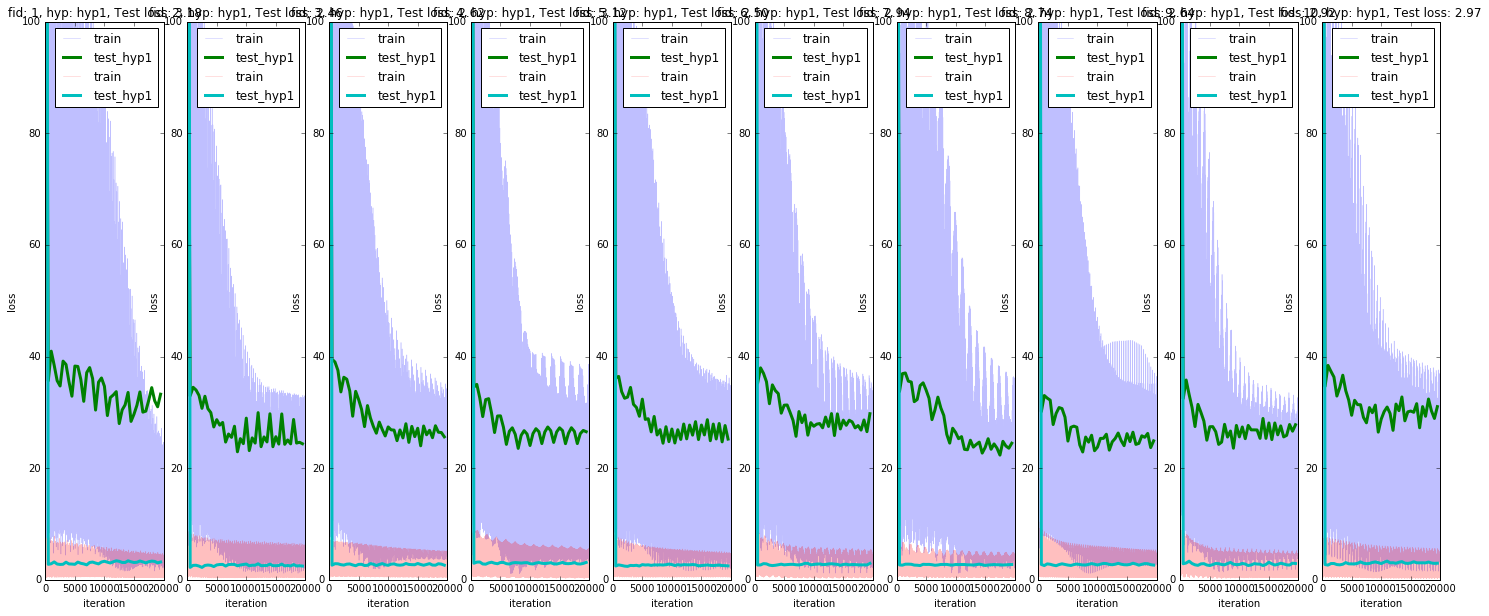

In [21]:
# plot train loss and acc
plt.rcParams['figure.figsize'] = (25, 10)
#niter = 30000
test_interval = 500
n_mc = len(CV_perf_MC.keys())

for m, mc in enumerate(CV_perf_MC.keys()): 
    CV_perf_hype = CV_perf_MC[mc]
    
    for hype in CV_perf_hype.keys(): 
        CV_perf = CV_perf_hype[hype]
        n_CV_configs = len(CV_perf)
        pid = m*n_CV_configs + 1
        
        for f, fid in enumerate(fid_list):  
            train_loss_list = CV_perf[fid]['train_loss']
            test_loss_list = CV_perf[fid]['test_loss']
            
            for train_loss, test_loss in zip(train_loss_list,test_loss_list):
                #plt.figure()
                ax1 = plt.subplot(n_mc,n_CV_configs,pid)            
                ax1.plot(arange(niter), train_loss, label='train',linewidth='.5',alpha=0.25)
                ax1.plot(test_interval * arange(len(test_loss)), test_loss, label='test_{}'.format(hype), linewidth='3')                            
                ax1.set_xlabel('iteration')
                ax1.set_ylabel('loss')
                ax1.set_title('fid: {}, hyp: {}, Test loss: {:.2f}'.format(fid, hype, test_loss[-1]))
                ax1.legend(loc=1)
                ax1.set_ylim(0,100)
            pid += 1

# Train-test performance 
* **Steps** 
    1. Get train and test performance different MC,KF and hyper-params
    2. Save Multi-task performance separately (ADAS & MMSE)

In [32]:
#Get encodings after training
#Get test performance 
#Save test performance for differnt folds + hyperparameters 
# niter = 20000
# start_fold = 1
# n_folds = 1
# fid_list = np.arange(start_fold,n_folds+1,1)
snap_interval = 2000
snap_start = 2000
encoding_layer = 'output'
weight_layers = 'output'
cohort = 'outer_test'

if Clinical_Scale in ['ADAS13', 'MMSE']:
    fold_euLoss = {}
    fold_r = {}
    fold_act_scores = {}
    fold_pred_scores = {}
elif Clinical_Scale == 'BOTH':
    fold_euLoss_adas13 = {}
    fold_r_adas13 = {}
    fold_act_scores_adas13 = {}
    fold_pred_scores_adas13 = {}
    fold_euLoss_mmse = {}
    fold_r_mmse = {}
    fold_act_scores_mmse = {}
    fold_pred_scores_mmse = {}
    
idx = 0  
df_perf_dict_adas = {}
df_perf_dict_mmse = {}
df_perf_dict_adas_tuned = {}
df_perf_dict_mmse_tuned = {}
df_perf_dict_opt = {}

for mc in MC_list:
    print exp_name, mc, modality

    for hype in hype_configs.keys():      
        node_sizes = hype_configs[hype]['node_sizes']
        dr = hype_configs[hype]['dr']
        lr = hype_configs[hype]['lr']

        for fid in fid_list:
            test_filename_txt = baseline_dir + 'API/data/MC_{}/fold{}/test_C688.txt'.format(mc,fid)
            #test_filename_hdf = baseline_dir + 'API/data/fold{}/outer_test/{}_{}.h5'.format(fid,exp_name,preproc)
            #with open(test_filename_txt, 'w') as f:
            #        f.write(test_filename_hdf + '\n')  

            test_net_path = baseline_dir + 'API/data/MC_{}/fold{}/ADNI_FF_test.prototxt'.format(mc,fid)
            with open(test_net_path, 'w') as f:
                if modality == 'HC':
                    f.write(str(adninet_ff_HC(test_filename_txt, batch_size, node_sizes,dr,lr,tr,Clinical_Scale)))
                    input_nodes = ['X_L_HC','X_R_HC']
                elif modality == 'CT':
                    f.write(str(adninet_ff_CT(test_filename_txt, batch_size, node_sizes,dr,lr,tr,Clinical_Scale)))
                    input_nodes = ['X_CT_SpecCluster_dyn']
                elif modality == 'HC_CT':
                    f.write(str(adninet_ff_HC_CT(test_filename_txt, batch_size, node_sizes,dr,lr,tr,Clinical_Scale)))
                    input_nodes = ['X_L_HC','X_R_HC','X_CT_SpecCluster_dyn']
                elif modality == 'HC_CT_unified_hyp1':
                    f.write(str(adninet_ff_HC_CT_unified(test_filename_txt, batch_size, node_sizes,dr,lr,tr,Clinical_Scale)))
                    input_nodes = ['X_HC_CT']
                else:
                    print 'Wrong modality'

            #print 'Hype # {}, MC # {}, Fold # {}, Clinical_Scale {}'.format(hype, mc, fid, Clinical_Scale)
            data_path = baseline_dir + 'API/data/MC_{}/fold{}/{}/{}.h5'.format(mc,fid,cohort,exp_name)
            if Clinical_Scale == 'ADAS13':
                act_scores = load_data(data_path, 'adas','no_preproc')
            elif Clinical_Scale == 'MMSE': 
                act_scores = load_data(data_path, 'mmse','no_preproc')
            elif Clinical_Scale == 'BOTH':
                act_scores_adas13 = load_data(data_path, 'adas','no_preproc')
                act_scores_mmse = load_data(data_path, 'mmse','no_preproc')
            else:
                print 'unknown clinical scale'

            net_file = baseline_dir + 'API/data/MC_{}/fold{}/ADNI_FF_test.prototxt'.format(mc,fid)
            test_filename_hdf = baseline_dir + 'API/data/MC_{}/fold{}/{}/{}.h5'.format(mc,fid,cohort,exp_name)
            test_filename_txt = baseline_dir + 'API/data/MC_{}/fold{}/{}_C688.txt'.format(mc,fid,cohort)
            with open(test_filename_txt, 'w') as f:
                    f.write(test_filename_hdf + '\n')  

            sub.call(["cp", baseline_dir + 'API/data/MC_{}/fold{}/{}_C688.txt'.format(mc,fid,cohort), baseline_dir + 
                      'API/data/MC_{}/fold{}/test_C688.txt'.format(mc,fid)])
            #data_path = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/CV_Exp4_ADNI1_ADAS13_NN_valid.h5'
            #adas_scores = load_data(data_path, 'Fold_{}_y'.format(fid),'no_preproc')

            if Clinical_Scale in ['ADAS13', 'MMSE']:                
                multi_task = False
                cs_list = ['opt']
                iter_euLoss = []
                iter_r = []        
                iter_pred_scores = []
                for snap_iter in np.arange(snap_start,niter+1,snap_interval):
                    model_file = baseline_dir + 'API/data/MC_{}/fold{}/train_snaps/{}_{}_{}_iter_{}.caffemodel'.format(mc,fid,exp_name,hype,modality,snap_iter)        
                    results = extract_features(net_file, model_file, data_path, input_nodes, batch_size, encoding_layer, weight_layers,multi_task)
                    encodings = np.squeeze(results['X_out'])            
                    iter_pred_scores.append(np.squeeze(results['X_out']))            
                    iter_euLoss.append(0.5*mse(encodings,act_scores))  #This is to be consistent with the caffe loss funtion
                    iter_r.append(stats.pearsonr(encodings,act_scores)[0])

                config_idx = '{}_{}'.format(hype,fid)
                fold_euLoss[config_idx] = np.array(iter_euLoss)
                fold_r[config_idx] = np.array(iter_r)
                fold_act_scores[fid] = act_scores
                fold_pred_scores[config_idx] = np.array(iter_pred_scores)        

            elif Clinical_Scale == 'BOTH':
                multi_task = True
                cs_list = ['adas','mmse']
                iter_euLoss_adas13 = []
                iter_r_adas13 = []        
                iter_pred_scores_adas13 = []
                iter_euLoss_mmse = []
                iter_r_mmse = []        
                iter_pred_scores_mmse = []

                for snap_iter in np.arange(snap_start,niter+1,snap_interval):
                    model_file = baseline_dir + 'API/data/MC_{}/fold{}/train_snaps/{}_{}_{}_iter_{}.caffemodel'.format(mc,fid,exp_name,hype,modality,snap_iter)        
                    results = extract_features(net_file, model_file, data_path, input_nodes, batch_size, encoding_layer, weight_layers,multi_task)
                    encodings = results['X_out']   
                    encodings_adas13 = np.squeeze(encodings['adas13'])
                    encodings_mmse = np.squeeze(encodings['mmse'])
                    iter_pred_scores_adas13.append(encodings_adas13)            
                    iter_pred_scores_mmse.append(encodings_mmse)                 
                    iter_euLoss_adas13.append(0.5*mse(encodings_adas13,act_scores_adas13))  #This is to be consistent with the caffe loss funtion
                    iter_euLoss_mmse.append(0.5*mse(encodings_mmse,act_scores_mmse))  #This is to be consistent with the caffe loss funtion
                    iter_r_adas13.append(stats.pearsonr(encodings_adas13,act_scores_adas13)[0])                                
                    iter_r_mmse.append(stats.pearsonr(encodings_mmse,act_scores_mmse)[0])

                config_idx = '{}_{}'.format(hype,fid)
                fold_euLoss_adas13[config_idx] = np.array(iter_euLoss_adas13)
                fold_r_adas13[config_idx] = np.array(iter_r_adas13)
                fold_act_scores_adas13[fid] = act_scores_adas13
                fold_pred_scores_adas13[config_idx] = np.array(iter_pred_scores_adas13)        
                fold_euLoss_mmse[config_idx] = np.array(iter_euLoss_mmse)
                fold_r_mmse[config_idx] = np.array(iter_r_mmse)
                fold_act_scores_mmse[fid] = act_scores_mmse
                fold_pred_scores_mmse[config_idx] = np.array(iter_pred_scores_mmse)        

    
    if Clinical_Scale in ['ADAS13', 'MMSE']:
        fold_perf_dict = {'fold_r':fold_r,'fold_euLoss':fold_euLoss,'fold_act_scores':fold_act_scores,'fold_pred_scores':fold_pred_scores}
    else: 
        fold_perf_dict = {'fold_r_adas13':fold_r_adas13,'fold_r_mmse':fold_r_mmse,'fold_euLoss_adas13':fold_euLoss_adas13,'fold_euLoss_mmse':fold_euLoss_mmse,
                         'fold_act_scores_adas13':fold_act_scores_adas13,'fold_act_scores_mmse':fold_act_scores_mmse,
                          'fold_pred_scores_adas13':fold_pred_scores_adas13,'fold_pred_scores_mmse':fold_pred_scores_mmse}
        
    opt_metric = 'euLoss' #euLoss or corr or both
    #task_weights = {'ADAS':1,'MMSE':0} 
    save_multitask_results = True
    CV_model_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/NN_MC/output/'  
    
    
    # Create dictionaries of perfromance based on differnt task weights 
    for key, task_weights in {'adas':{'ADAS':1,'MMSE':0},'mmse':{'ADAS':0,'MMSE':1},'both':{'ADAS':1,'MMSE':1}}.items():
        print 'Weights Tuned for: {}'.format(key)            
        save_path = '{}{}_{}_NN_{}_{}'.format(CV_model_dir,exp_name,mc,modality,key)
        results = compute_MC_results(fold_perf_dict, multi_task, opt_metric, task_weights, save_multitask_results, save_path)  

        # populate the perf dictionary for 10 MC x 10 folds
        model_choice = 'APANN'    
        for f, fid in enumerate(fid_list): 
            if key in ['adas','mmse']:
                r_valid = results['{}_r'.format(key)][f]
                MSE_valid = results['{}_mse'.format(key)][f]
                RMSE_valid = results['{}_rmse'.format(key)][f]

                if key == 'adas':
                    df_perf_dict_adas_tuned[idx] = {'MC':mc,'modality':modality,'model_choice':model_choice,'KF':fid,
                                         'CV_MSE':MSE_valid,'CV_RMSE':RMSE_valid,'CV_r':r_valid,'CV_R2':0}
                elif key == 'mmse':
                    df_perf_dict_mmse_tuned[idx] = {'MC':mc,'modality':modality,'model_choice':model_choice,'KF':fid,
                                         'CV_MSE':MSE_valid,'CV_RMSE':RMSE_valid,'CV_r':r_valid,'CV_R2':0}
                else: 
                    print 'unknown key'

            elif key == 'both':                    
                for cs in cs_list:            
                    r_valid = results['{}_r'.format(cs)][f]
                    MSE_valid = results['{}_mse'.format(cs)][f]
                    RMSE_valid = results['{}_rmse'.format(cs)][f]

                    if cs == 'adas':
                        df_perf_dict_adas[idx] = {'MC':mc,'modality':modality,'model_choice':model_choice,'KF':fid,
                                         'CV_MSE':MSE_valid,'CV_RMSE':RMSE_valid,'CV_r':r_valid,'CV_R2':0}
                    elif cs == 'mmse':
                        df_perf_dict_mmse[idx] = {'MC':mc,'modality':modality,'model_choice':model_choice,'KF':fid,
                                         'CV_MSE':MSE_valid,'CV_RMSE':RMSE_valid,'CV_r':r_valid,'CV_R2':0}                    
                    else: 
                        print 'unknown key'


            else: #single task dictionary
                df_perf_dict_opt[idx] = {'MC':mc,'modality':modality,'model_choice':model_choice,'KF':fid,
                                         'CV_MSE':MSE_valid,'CV_RMSE':RMSE_valid,'CV_r':r_valid,'CV_R2':0}

            idx+=1

Exp6_MC 1 HC_CT
Weights Tuned for: both
Clinical_Scale: BOTH
ADAS corr: [0.59982196591503578, 0.50032959377325215, 0.64923619779493336, 0.63097152176777915, 0.5683214180072812, 0.69879090275830791, 0.40626403687383583, 0.6185930707658488, 0.54950331132586272, 0.48296171684955536]
ADAS mse: [48.511366887976791, 56.432210449146503, 45.034965720760056, 57.800644579354461, 44.386356457109478, 36.357722667653043, 74.569069140610537, 45.327362615174891, 42.476688481338272, 92.352244728744992]
ADAS means: 0.570479373583, 54.3248631728

MMSE corr: [0.49918106660281758, 0.46198639743279735, 0.50405871058869911, 0.45354655461463267, 0.55132645553122073, 0.57205194822222194, 0.46909462491152371, 0.58979565884397189, 0.39499800796998663, 0.5086248019160815]
MMSE mse: [5.1384512548907768, 5.5200841997290864, 4.4754550324664972, 6.2323775864229258, 5.7483310370655945, 5.0598235327030778, 6.5330748461015133, 3.9709354706109012, 4.9845308641523633, 5.5778515442291301]
MMSE means: 0.500466422663, 5.324

In [ ]:
#Save df style dictionaly for seaborn plots
cohort = 'ADNI1'
update = 1
df_perf_dict_path = CV_model_dir + 'df_perf_dict_{}_{}_{}_ADAS13_up_{}.pkl'.format(exp_name, cohort,modality,update)                
pickleIt(df_perf_dict_adas,df_perf_dict_path)
df_perf_dict_path = CV_model_dir + 'df_perf_dict_{}_{}_{}_MMSE_up_{}.pkl'.format(exp_name, cohort,modality,update)  
pickleIt(df_perf_dict_mmse,df_perf_dict_path)

df_perf_dict_path = CV_model_dir + 'df_perf_dict_{}_{}_{}_ADAS13_tuned_up_{}.pkl'.format(exp_name,cohort,modality,update)                
pickleIt(df_perf_dict_adas_tuned,df_perf_dict_path)
df_perf_dict_path = CV_model_dir + 'df_perf_dict_{}_{}_{}_MMSE_tuned_up_{}.pkl'.format(exp_name, cohort,modality,update)  
pickleIt(df_perf_dict_mmse_tuned,df_perf_dict_path)


print 'saving results at: {}'.format(CV_model_dir)

In [36]:
2107*4/60/60.0

2.3333333333333335

In [30]:
def compute_MC_results(fold_perf_dict, multi_task, opt_metric, task_weights, save_multitask_results, save_path):
    fold_r_dict = {}
    fold_euLoss_dict = {}
    fold_act_scores_dict = {}
    fold_pred_scores_dict = {}

    if multi_task:
        fold_r_dict['ADAS'] = fold_perf_dict['fold_r_adas13']
        fold_r_dict['MMSE'] = fold_perf_dict['fold_r_mmse']
        fold_euLoss_dict['ADAS'] = fold_perf_dict['fold_euLoss_adas13']
        fold_euLoss_dict['MMSE'] = fold_perf_dict['fold_euLoss_mmse']
        fold_act_scores_dict['ADAS'] = fold_perf_dict['fold_act_scores_adas13']
        fold_act_scores_dict['MMSE'] = fold_perf_dict['fold_act_scores_mmse']
        fold_pred_scores_dict['ADAS'] = fold_perf_dict['fold_pred_scores_adas13']
        fold_pred_scores_dict['MMSE'] = fold_perf_dict['fold_pred_scores_mmse']
        
        NN_results = computePerfMetrics(fold_r_dict, fold_euLoss_dict, fold_act_scores_dict, fold_pred_scores_dict, opt_metric, hype_configs, 
                                        Clinical_Scale,task_weights)
        adas_r = NN_results['opt_ADAS']['CV_r'].values()
        mmse_r = NN_results['opt_MMSE']['CV_r'].values()
        adas_mse = NN_results['opt_ADAS']['CV_MSE'].values()
        mmse_mse = NN_results['opt_MMSE']['CV_MSE'].values()
        adas_rmse = NN_results['opt_ADAS']['CV_RMSE'].values()
        mmse_rmse = NN_results['opt_MMSE']['CV_RMSE'].values()
        opt_hyp = NN_results['opt_hype']
        opt_snap = NN_results['opt_snap']
        predicted_CV_scores = NN_results['opt_ADAS']['predicted_CV_scores']
        actual_CV_scores = NN_results['opt_ADAS']['actual_CV_scores']
        
        print 'ADAS corr: {}'.format(adas_r)
        print 'ADAS mse: {}'.format(adas_mse)
        print 'ADAS means: {}, {}'.format(np.mean(adas_r),np.mean(adas_mse))
        print ''
        print 'MMSE corr: {}'.format(mmse_r)
        print 'MMSE mse: {}'.format(mmse_mse)
        print 'MMSE means: {}, {}'.format(np.mean(mmse_r),np.mean(mmse_mse))
        print ''
        print 'opt_hyp: {}'.format(opt_hyp)
        print ''
        print 'opt_snap: {}'.format(opt_snap)
        
        if save_multitask_results:
            ts = time.time()
            st = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d-%H-%M-%S')        
            save_path = save_path + '_' + st + '.pkl' 
            print 'saving results at: {}'.format(save_path)
            output = open(save_path, 'wb')
            pickle.dump(NN_results, output)
            output.close()
        
        return {'adas_r':adas_r, 'adas_mse':adas_mse, 'adas_rmse':adas_rmse, 'mmse_r':mmse_r, 'mmse_mse':mmse_mse, 'mmse_rmse':mmse_rmse,
               'predicted_CV_scores':predicted_CV_scores,'actual_CV_scores':actual_CV_scores}

    else:    
        
        NN_results = computeSingleTaskPerfMetrics(fold_perf_dict, opt_metric, hype_configs)
        opt_r = NN_results['opt_r'].values()        
        opt_mse = NN_results['opt_mse'].values()        
        opt_rmse = NN_results['opt_rmse'].values()        
        opt_hyp = NN_results['opt_hype']
        opt_snap = NN_results['opt_snap']
        predicted_CV_scores = NN_results['predicted_CV_scores']
        actual_CV_scores = NN_results['actual_CV_scores']
        print 'opt corr: {}'.format(opt_r)
        print 'opt mse: {}'.format(opt_mse)
        print 'means: {}, {}'.format(np.mean(opt_r),np.mean(opt_mse))
        print ''
        print 'opt_snap: {}'.format(opt_snap)
        print ''
        
        if save_multitask_results:
            ts = time.time()
            st = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d-%H-%M-%S')        
            save_path = save_path + '_' + st + '.pkl' 
            print 'saving results at: {}'.format(save_path)
            output = open(save_path, 'wb')
            pickle.dump(NN_results, output)
            output.close()
    
        return {'opt_r':opt_r, 'opt_mse':opt_mse, 'opt_rmse':opt_rmse,'predicted_CV_scores':predicted_CV_scores,'actual_CV_scores':actual_CV_scores}
    

In [17]:
# Compute ptimal hyp_config for each fold(based on inner_test)
# if multi_task is set then compute hyp_config based on ADAS+MMSE perf (mse, r values)
# if multi_task is set then ADAS and MMSE act_scores and pred_scores are wrapped in dictionaries 
# task_weights: dict of weights for each task --> only used in Clinical_Scale = BOTH
# opt_metric = mse or corr
def computePerfMetrics(fold_r, fold_euLoss, fold_act_scores, fold_pred_scores, opt_metric, hype_configs, Clinical_Scale,task_weights):
    # First generate lists per fold with all hyp results
    fid_hype_map = defaultdict(list)
    fid_euLoss_perf= defaultdict(list)
    fid_r_perf= defaultdict(list)
    
     # find optimal hyp_snp combination for each fold based on corr and euLoss
    opt_hype = {}
    opt_snap = {}

    opt_r_adas = {}
    opt_mse_adas = {}
    opt_rmse_adas = {}
    actual_scores_adas = defaultdict(list)
    opt_pred_scores_adas = defaultdict(list)

    opt_r_mmse = {}
    opt_mse_mmse = {}
    opt_rmse_mmse = {}
    actual_scores_mmse = defaultdict(list)
    opt_pred_scores_mmse = defaultdict(list)

    print 'Clinical_Scale: {}'.format(Clinical_Scale)
    if not Clinical_Scale == 'BOTH':  #Does not produce all the metrics yet..
        print 'This function does not work for single clinical scale models. Use the code from the next cell'
    
    else:
        fold_r_ADAS = fold_r['ADAS']
        fold_r_MMSE = fold_r['MMSE']
        fold_euLoss_ADAS = fold_euLoss['ADAS']
        fold_euLoss_MMSE = fold_euLoss['MMSE']
        fid_r_perf_ADAS = defaultdict(list)
        fid_r_perf_MMSE = defaultdict(list)
        fid_euLoss_perf_ADAS = defaultdict(list)
        fid_euLoss_perf_MMSE = defaultdict(list)
        for hype_fid in fold_euLoss_ADAS.keys():
            hype = int(hype_fid.split('_')[0][3])
            fid = int(hype_fid.split('_')[1]) 
            
            fid_r_perf_ADAS[fid].append(fold_r_ADAS[hype_fid])
            fid_r_perf_MMSE[fid].append(fold_r_MMSE[hype_fid])
            fid_euLoss_perf_ADAS[fid].append(fold_euLoss_ADAS[hype_fid])
            fid_euLoss_perf_MMSE[fid].append(fold_euLoss_MMSE[hype_fid])
            fid_hype_map[fid].append(hype)
            
            #Joint scores (weighted addition)
            fid_r_perf[fid].append(task_weights['ADAS']*fold_r_ADAS[hype_fid] + task_weights['MMSE']*fold_r_MMSE[hype_fid])
            fid_euLoss_perf[fid].append(task_weights['ADAS']*fold_euLoss_ADAS[hype_fid] + task_weights['MMSE']*fold_euLoss_MMSE[hype_fid])

        fold_act_scores_adas = fold_act_scores['ADAS']
        fold_act_scores_mmse = fold_act_scores['MMSE']
        fold_pred_scores_adas = fold_pred_scores['ADAS']
        fold_pred_scores_mmse = fold_pred_scores['MMSE']

        for fid in fid_hype_map.keys():
            r_perf_array_adas = np.array(fid_r_perf_ADAS[fid])
            r_perf_array_mmse = np.array(fid_r_perf_MMSE[fid])
            r_perf_array = np.array(fid_r_perf[fid])
            euLoss_perf_array_adas = np.array(fid_euLoss_perf_ADAS[fid])
            euLoss_perf_array_mmse = np.array(fid_euLoss_perf_MMSE[fid])
            euLoss_perf_array = np.array(fid_euLoss_perf[fid])

            if opt_metric == 'euLoss':
                h,snp = np.unravel_index(euLoss_perf_array.argmin(), euLoss_perf_array.shape)
            else:
                h,snp = np.unravel_index(r_perf_array.argmax(), r_perf_array.shape)

            opt_hype[fid] = hype_configs['hyp{}'.format(fid_hype_map[fid][h])]
            opt_snap[fid] = snp

            opt_r_adas[fid] = r_perf_array_adas[h,snp]
            opt_mse_adas[fid] = 2*euLoss_perf_array_adas[h,snp] #Convert back to MSE
            opt_rmse_adas[fid] = np.sqrt(2*euLoss_perf_array_adas[h,snp]) #RMSE
            opt_r_mmse[fid] = r_perf_array_mmse[h,snp] 
            opt_mse_mmse[fid] = 2*euLoss_perf_array_mmse[h,snp] #Convert back to MSE
            opt_rmse_mmse[fid] = np.sqrt(2*euLoss_perf_array_mmse[h,snp]) #RMSE

            actual_scores_adas[fid].append(fold_act_scores_adas[fid])
            opt_pred_scores_adas[fid].append(fold_pred_scores_adas['hyp{}_{}'.format(fid_hype_map[fid][h],fid)][snp])
            actual_scores_mmse[fid].append(fold_act_scores_mmse[fid])
            opt_pred_scores_mmse[fid].append(fold_pred_scores_mmse['hyp{}_{}'.format(fid_hype_map[fid][h],fid)][snp])

        opt_ADAS = {'CV_r':opt_r_adas,'CV_MSE':opt_mse_adas,'CV_RMSE':opt_rmse_adas,'actual_CV_scores':actual_scores_adas,'predicted_CV_scores':opt_pred_scores_adas}
        opt_MMSE = {'CV_r':opt_r_mmse,'CV_MSE':opt_mse_mmse,'CV_RMSE':opt_rmse_mmse,'actual_CV_scores':actual_scores_mmse,'predicted_CV_scores':opt_pred_scores_mmse}
    
    return {'opt_hype':opt_hype, 'opt_snap':opt_snap, 'opt_ADAS':opt_ADAS, 'opt_MMSE':opt_MMSE}


In [ ]:
# Find optimal config based on inner_test
def computeSingleTaskPerfMetrics(fold_perf_dict,opt_metric,hype_configs):
    corrs = fold_perf_dict['fold_r']
    euLosses = fold_perf_dict['fold_euLoss']
    act_scores = fold_perf_dict['fold_act_scores']
    pred_scores = fold_perf_dict['fold_pred_scores']

    
    NN_multitask_results = {}
   
    snap_array = np.arange(snap_start,niter+1,snap_start)

    fid_hype_map = defaultdict(list)
    fid_euLoss_perf= defaultdict(list)
    fid_r_perf= defaultdict(list)
    for hype_fid in fold_euLoss.keys():
        hype = int(hype_fid.split('_')[0][3])
        fid = int(hype_fid.split('_')[1])
        fid_euLoss_perf[fid].append(fold_euLoss[hype_fid])
        fid_r_perf[fid].append(fold_r[hype_fid])
        fid_hype_map[fid].append(hype)

    opt_r = {}
    opt_mse = {}
    opt_rmse = {}
    opt_hype = {}
    opt_snap = {}
    actual_scores = {}
    opt_pred_scores = {}

    for fid in fid_hype_map.keys():
        r_perf_array = np.array(fid_r_perf[fid])
        euLoss_perf_array = np.array(fid_euLoss_perf[fid])

        # if want to find best hyp from mse values
        if opt_metric == 'euLoss':
            h,snp = np.unravel_index(euLoss_perf_array.argmin(), euLoss_perf_array.shape)
        else:
            h,snp = np.unravel_index(r_perf_array.argmax(), r_perf_array.shape)
            
        eu_loss = euLoss_perf_array[h,snp]
        r = r_perf_array[h,snp]        
        opt_r[fid] = r
        opt_mse[fid] = 2*eu_loss
        opt_rmse[fid] = np.sqrt(2*eu_loss)
        #print 'fid:{}, best hype:{}, snap: {}, euLoss:{}'.format(fid, fid_hype_map[fid][h],snap_array[snp],eu_loss)        
        opt_snap[fid] = snp
        opt_hype[fid] = hype_configs['hyp{}'.format(fid_hype_map[fid][h])]
        actual_scores[fid] = fold_act_scores[fid]
        opt_pred_scores[fid] = fold_pred_scores['hyp{}_{}'.format(fid_hype_map[fid][h],fid)][snp]

    #print 'CV Perf: r:{}, mse:{}'.format(np.mean(opt_r.values()), np.mean(opt_mse.values()))
    #print opt_r
    #print opt_mse
    return {'opt_r':opt_r,'opt_mse':opt_mse,'opt_rmse':opt_rmse,'opt_hype':opt_hype,'opt_snap':opt_snap, 'actual_scores':actual_scores,'opt_pred_scores':opt_pred_scores}


# Net surgery FF pretrained weights
* **Steps** 
    1. Copy weights from pre-trained models from individual modalities (HC,CT)
    2. Use these weights as initializations for the HC+CT net (only lower layers for indvidual modalities)

In [ ]:
#Review new FF net params
cohort = 'ADNI2'
modality = 'HC_CT'
pretrain_snap_HC = 20000 #ADNI1: 5000
pretrain_snap_CT = 20000 #ADNI1: 5000
n_folds = 10
baseline_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/NN_MC/' 
#Custom snaps per fold
#HC_iter = [8000,8000,8000,8000,6000,6000,8000,8000,8000,6000]
#CT_iter = [12000,12000,12000,12000,12000,6000,6000,6000,6000,6000]
#mc=1
hc_hyp = 'hyp1'
ct_hyp = 'hyp1'
pretrain_hyp = 'hyp2' #This is hyp generated using optimal combination of hc and ct hyps. Prototxt file is saved with this hyp extension

exp_name = 'Exp11_MC'

for mc in np.arange(6,11,1):
    for fid in np.arange(1,n_folds+1,1):
        print 'fid: {}'.format(fid)
        #for AE_branch in ['CT','R_HC','L_HC']:
        for AE_branch in ['CT','HC']:
            print 'AE_branch: {}'.format(AE_branch)

            if AE_branch == 'L_HC':
                params_FF = ['L_ff1', 'L_ff2']            
                AE_iter = 12000
            elif AE_branch == 'R_HC':
                params_FF = ['R_ff1', 'R_ff2']            
                AE_iter = 12000
            elif AE_branch == 'HC':
                params_FF = ['L_ff1','R_ff1']
                AE_iter = pretrain_snap_HC
                hyp = hc_hyp
            elif AE_branch == 'CT':
                #params_FF = ['ff1', 'ff2']
                params_FF = ['ff1']
                AE_iter = pretrain_snap_CT
                hyp = ct_hyp
                #fid for pretain is 1 because it's same definition for all the folds.
                #Only use this during 1 of the modalities to avoid overwritting
                print 'Spawning new net'
                pretrain_net = caffe.Net(baseline_dir + 'API/data/MC_{}/fold{}/ADNI_FF_train_{}_{}.prototxt'.format(mc,fid,pretrain_hyp,modality), caffe.TRAIN)
            else:
                print 'Wrong AE branch'

            # conv_params = {name: (weights, biases)}
            conv_params = {pr: (pretrain_net.params[pr][0].data, pretrain_net.params[pr][1].data) for pr in params_FF}

            for conv in params_FF:
                print 'target {} weights are {} dimensional and biases are {} dimensional'.format(conv, conv_params[conv][0].shape, conv_params[conv][1].shape)

            # Review AE net params 
            #fid for pretain is 1 because it's same definition for all the folds.
            net_file = baseline_dir + 'API/data/MC_{}/fold{}/ADNI_FF_train_{}_{}.prototxt'.format(mc,fid,hyp,AE_branch)
            #model_file = baseline_dir + 'API/data/fold{}/train_snaps/AE_snaps/AE_{}_iter_{}.caffemodel'.format(fid,AE_branch,AE_iter) 
            model_file = baseline_dir + 'API/data/MC_{}/fold{}/train_snaps/{}_{}_{}_iter_{}.caffemodel'.format(mc,fid,exp_name,hyp,AE_branch,AE_iter) 

            AE_net = caffe.Net(net_file, model_file, caffe.TEST)
            #params_AE = ['encoder1', 'code']
            params_AE = params_FF #if you are using pretrained NN

            # fc_params = {name: (weights, biases)}
            fc_params = {pr: (AE_net.params[pr][0].data, AE_net.params[pr][1].data) for pr in params_AE}

            for fc in params_AE:
                print 'pretrained {} weights are {} dimensional and biases are {} dimensional'.format(fc, fc_params[fc][0].shape, fc_params[fc][1].shape)

            #transplant net parameters
            for pr, pr_conv in zip(params_AE, params_FF):
                conv_params[pr_conv][0].flat = fc_params[pr][0].flat  # flat unrolls the arrays
                conv_params[pr_conv][1][...] = fc_params[pr][1]

            save_net = True
            if save_net:
                net_name = 'API/data/MC_{}/fold{}/pretrained_models/{}_ff_{}_{}_HC_snap_{}_CT_snap_{}_Sup_Concat.caffemodel'
                save_path = baseline_dir + net_name.format(mc,fid,cohort,pretrain_hyp,modality,pretrain_snap_HC,pretrain_snap_CT)
                print "Saving net to " + save_path
                pretrain_net.save(save_path)